# BELTRANS Data Integration Analysis

This notebook contains an analysis of data from the BELTRANS project.

Before this analysis, each data source was loaded into different "namespaces" of our **Blazegraph** triple store. Data sources which are already in RDF were directly uploaded to the triple store, heterogeneous data were first mapped to RDF via [rml.io](https://rml.io).

We use `SPARQL` queries to investigate for the different data sources how they overlap. The objective is to identify optimal integration strategies with increase the size and interoperability of KBR authority data.

# Table of Contents

1. [Goals](#Goals)
2. [Approach](#Approach)
3. [Integration Steps](#Integration-steps)<br>
  3.1. [Enrich with identifiers](#Enrich-with-identifiers)<br>
  3.2. [Enrich with nationalities](#Enrich-with-nationalities)<br>
  3.3. [Enrich with new authorities](#Enrich-with-new-authorities)<br>

In [1]:
import sys
import pandas as pd
import matplotlib
sys.path.insert(0, '../utils/')

from SPARQLWrapper import SPARQLWrapper, TURTLE, JSON
import sparql_utils

# Establish connections to SPARQL endpoints
endpointKBR = SPARQLWrapper('http://wikibase-test-srv01.kbr.be/sparql/namespace/kbr-belgians/sparql')
endpointWikidataBelgians = SPARQLWrapper('http://wikibase-test-srv01.kbr.be/sparql/namespace/wikidata-belgians/sparql')
endpointBnf = SPARQLWrapper('http://wikibase-test-srv01.kbr.be/sparql/namespace/bnf-authors-persons/sparql')
endpointNTA = SPARQLWrapper('http://wikibase-test-srv01.kbr.be/sparql/namespace/kb-authors-nta/sparql')

## Goals
We specify the goals of data integration so we can measure and validate the outcome of our integration activities.

1. We need to get Belgian authors we do not have already in our KBR authors dataset 
  * *-> This increases the size of authority data at KBR*
2. We need to enrich KBR authors without nationality with any found nationality 
  * *-> This marks authors in our dataset as non-Belgians and for the future we can prioritize them lower*
3. We need to enrich KBR authors without nationality with Belgian nationality if they have it 
  * *-> This marks authors in our dataset as Belgians and for the future we can prioritize them*
4. We need to enrich KBR authors with missing ISNI and VIAF numbers
  * *-> This increaes interoperability (similar for the following two goals)*
5. We need to enrich KBR authors with identifiers from other libraries
6. We need to enrich KBR authors with common identifiers such as Wikidata or DBpedia


## Initial statistics
Before integration we measure the following values related to the goals defined above.
We measure the values based on two data sources, an export of Belgian authors from the KBR Syracuse system,
and a Wikidata export of Belgians optionally including other identifeirs, manually enriched with KBR identifiers.

In [2]:
# getInitialGoalStats()

# Todo: get the following data once we have access to a complete Syracuse dump
# number authors: 800,000
# number no nationality known authors
# number of records with ISNI number
# number of records with VIAF number
# number of records with link to BnF
# number of records with link to KB
# number of records with link to DNB
# number of records with link to Wikidata

# number Belgian authors
belgianKBRAuthors = sparql_utils.getNumberOfBelgiansLOCURI(endpointKBR)
belgianKBRAuthorsWithISNI = sparql_utils.getNumberOfBelgiansWithISNI(endpointKBR)
belgianKBRAuthorsWithVIAF = sparql_utils.getNumberOfBelgiansWithIdentifier(endpointKBR, 'VIAF')

belgianWikidata = sparql_utils.getNumberOfBelgiansLOCURI(endpointWikidataBelgians)
belgianWikidataWithISNI = sparql_utils.getNumberOfBelgiansWithISNI(endpointWikidataBelgians)
belgianWikidataWithKBR = sparql_utils.getNumberOfBelgiansWithIdentifier(endpointWikidataBelgians, 'KBR')
belgianWikidataWithBnF = sparql_utils.getNumberOfBelgiansWithIdentifier(endpointWikidataBelgians, "BnF")
belgianWikidataWithKB = sparql_utils.getNumberOfBelgiansWithIdentifier(endpointWikidataBelgians, "NTA")
belgianWikidataWithDNB = sparql_utils.getNumberOfBelgiansWithIdentifier(endpointWikidataBelgians, "DNB")

# Todo create a data frame to store every value also with percentages to nicely display it
kbrData = [
    ['KBR Belgians', 'ISNI', belgianKBRAuthorsWithISNI, belgianKBRAuthors],
    ['KBR Belgians', 'VIAF', belgianKBRAuthorsWithVIAF, belgianKBRAuthors],
    ['KBR Belgians', 'KBR', belgianKBRAuthors, belgianKBRAuthors],
    ['Wikidata Belgians', 'ISNI', belgianWikidataWithISNI, belgianWikidata],
    ['Wikidata Belgians', 'KBR', belgianWikidataWithKBR, belgianWikidata],
    ['Wikidata Belgians', 'BnF', belgianWikidataWithBnF, belgianWikidata],
    ['Wikidata Belgians', 'NTA', belgianWikidataWithKB, belgianWikidata],
    ['Wikidata Belgians', 'DNB', belgianWikidataWithDNB, belgianWikidata] 
]

initialStats = pd.DataFrame(kbrData, columns=["Source", "Identifier", "Count", "Total"])
initialStats['Percentage'] = (initialStats['Count']/initialStats['Total'])*100

f"In total we have {belgianKBRAuthors} Belgians in the KBR catalogue and {belgianWikidata} Belgians found in Wikidata"

'In total we have 18009 Belgians in the KBR catalogue and 51930 Belgians found in Wikidata'

From these data we get the following percentage of references to other identifiers

In [3]:
initialStatsPivot = initialStats.pivot(index="Source", columns="Identifier", values="Percentage").fillna(0).round(2)
initialStatsPivot

Identifier,BnF,DNB,ISNI,KBR,NTA,VIAF
Source,,,,,,
KBR Belgians,0.00,0.00,36.14,100.00,0.0,1.22
Wikidata Belgians,11.71,10.29,19.37,4.58,14.6,0.00


<AxesSubplot:xlabel='Source'>

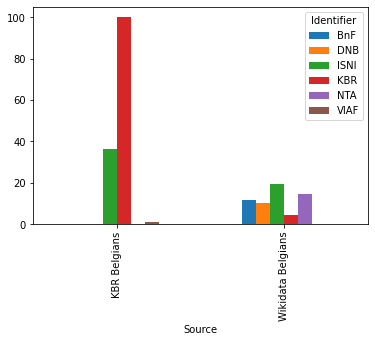

In [4]:
initialStatsPivot.plot(kind='bar')


## Approach
We define how we want to achieve the goals using existing data sources.

Each data source is represented as RDF and can be queried using SPARQL. If a data source is not yet represented in RDF we lift it to RDF using the framework [rml.io](https://rml.io).

Generally, we have two phases. Firstly we identify missing information based on linking, and secondly we query information to enriche our KBR data. The second phase may involve manual tasks.

Please note that ISNI and VIAF can be used in two ways: either as identifiers within KBR data and other data sources which enable linking, or as dedicated data source because ISNI (issued by OCLC) and VIAF provide data dumps themselves.

### Complement KBR data with new Belgians
To achieve goal *1.* we can ask the following question per data source to identify relevant data:

* Which authors have Belgian nationality?

Therefore we identify Belgians in the source. However, some of these identififed Belgians may already be in our KBR data. Using identifiers such as ISNI or VIAF which are present in the KBR data we can narrow the initial search result down to a smaller dataset. This smaller dataset can then be further analyzed automatically regarding overlap to KBR data based on entity linking techniques, manual checks or a combination of both.


### Identify unknown nationalities in KBR data
To achieve goal *2.* and *3.* we can ask the following questions per data source to identify relevant data.

* Which KBR authors without nationality are actually Belgians?
* Which KBR authors with other than a Belgian nationality are *also* Belgians?
* Which KBR authors without nationality do have a known nationality other than Belgian?

KBR authors with unknown nationality can be supplemented with nationality information based on linking KBR authors to data sources based on library-related identifiers such as ISNI and VIAF or common identifiers such as Wikidata or DBpedia. 

### Enrich KBR data with authority-related identifiers
To achieve goal *4.* we can ask the following questions per data source to identify relevant data.

* Which (Belgian) KBR authors are present in a data source and have a VIAF or ISNI number?

Since obvously we only use KBR authors without such identifiers as starting point, we have to link to data sources via other identifiers such as library identifiers or Wikidata to find matches and extract possible VIAF and ISNI numbers.

### Enrich KBR data with identifiers from other libraries
This is similar to the previous section, but instead of using identifiers of other libraries to identify VIAF and ISNI numbers we want to find identifiers of other libraries. Therefore the following question can be asked per data source to achieve goal *5.* and identify relevant data.

* Which (Belgian) KBR authors are present in a data source and have other library identifiers?

### Enrich KBR data with common identifiers
There is already a wikidata dump manually enriched with KBR identifiers. For other sources such as DBpedia we can ask the following question per data source to identify relevant data.

* Which (Belgian) KBR authors are present in a data source and have a link to a common identifier?


## Integration steps
We apply the aforementioned approach to our data sources. We start with steps to enrich data with identifiers and enrich nationality information before executing steps to add new data because the former steps help to determine what is "new".

### Enrich with identifiers

In [5]:
# Get the overlap of KBR to KB via identifier
# find out how many have ISNI and how many will have ISNI after enriching with KB knowledge graph data

wikidataBelgiansIdentifiers = sparql_utils.getWikidataBelgiansIdentifiers(endpointWikidataBelgians)
kbIdentifiers = sparql_utils.getKBIdentifiers(endpointNTA)

/home/slieber/repos/beltrans-data/data-sources/../utils/sparql_utils.py:121: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  return json_normalize(result['results']['bindings'])


EndPointInternalError: EndPointInternalError: endpoint returned code 500 and response. 

Response:
b'SPARQL-QUERY: queryStr=prefix bf: <http://id.loc.gov/ontologies/bibframe/>\nprefix schema: <http://schema.org/>\n\nSELECT DISTINCT ?kbKbID (strafter(str(?viaf), "viaf.org/viaf/") as ?kbViafID) (strafter(str(?isni), "isni.org/isni/") as ?kbIsniID)\nWHERE {\n  \n  ?meta a schema:WebPage ;\n          <http://data.bibliotheken.nl/def#ppn> ?kbKbID ;\n          schema:mainEntity ?person .\n  \n  ?person a schema:Person .\n  \n  OPTIONAL {\n    ?person schema:sameAs ?isni .\n    FILTER(regex(str(?isni), \'isni\', \'i\'))\n  }\n  \n  OPTIONAL {\n    ?person schema:sameAs ?viaf .\n    FILTER(regex(str(?viaf), \'viaf\', \'i\'))\n  }\n  \n}\n\n\njava.util.concurrent.ExecutionException: java.util.concurrent.ExecutionException: org.openrdf.query.QueryEvaluationException: java.lang.RuntimeException: java.util.concurrent.ExecutionException: java.lang.OutOfMemoryError: GC overhead limit exceeded\n\tat java.util.concurrent.FutureTask.report(FutureTask.java:122)\n\tat java.util.concurrent.FutureTask.get(FutureTask.java:192)\n\tat com.bigdata.rdf.sail.webapp.BigdataServlet.submitApiTask(BigdataServlet.java:294)\n\tat com.bigdata.rdf.sail.webapp.QueryServlet.doSparqlQuery(QueryServlet.java:678)\n\tat com.bigdata.rdf.sail.webapp.QueryServlet.doGet(QueryServlet.java:290)\n\tat com.bigdata.rdf.sail.webapp.RESTServlet.doGet(RESTServlet.java:240)\n\tat com.bigdata.rdf.sail.webapp.MultiTenancyServlet.doGet(MultiTenancyServlet.java:273)\n\tat javax.servlet.http.HttpServlet.service(HttpServlet.java:687)\n\tat javax.servlet.http.HttpServlet.service(HttpServlet.java:790)\n\tat org.eclipse.jetty.servlet.ServletHolder.handle(ServletHolder.java:873)\n\tat org.eclipse.jetty.servlet.ServletHandler$CachedChain.doFilter(ServletHandler.java:1623)\n\tat org.eclipse.jetty.websocket.server.WebSocketUpgradeFilter.doFilter(WebSocketUpgradeFilter.java:214)\n\tat org.eclipse.jetty.servlet.ServletHandler$CachedChain.doFilter(ServletHandler.java:1610)\n\tat org.eclipse.jetty.servlet.ServletHandler.doHandle(ServletHandler.java:540)\n\tat org.eclipse.jetty.server.handler.ScopedHandler.handle(ScopedHandler.java:146)\n\tat org.eclipse.jetty.security.SecurityHandler.handle(SecurityHandler.java:548)\n\tat org.eclipse.jetty.server.handler.HandlerWrapper.handle(HandlerWrapper.java:132)\n\tat org.eclipse.jetty.server.handler.ScopedHandler.nextHandle(ScopedHandler.java:257)\n\tat org.eclipse.jetty.server.session.SessionHandler.doHandle(SessionHandler.java:1700)\n\tat org.eclipse.jetty.server.handler.ScopedHandler.nextHandle(ScopedHandler.java:255)\n\tat org.eclipse.jetty.server.handler.ContextHandler.doHandle(ContextHandler.java:1345)\n\tat org.eclipse.jetty.server.handler.ScopedHandler.nextScope(ScopedHandler.java:203)\n\tat org.eclipse.jetty.servlet.ServletHandler.doScope(ServletHandler.java:480)\n\tat org.eclipse.jetty.server.session.SessionHandler.doScope(SessionHandler.java:1667)\n\tat org.eclipse.jetty.server.handler.ScopedHandler.nextScope(ScopedHandler.java:201)\n\tat org.eclipse.jetty.server.handler.ContextHandler.doScope(ContextHandler.java:1247)\n\tat org.eclipse.jetty.server.handler.ScopedHandler.handle(ScopedHandler.java:144)\n\tat org.eclipse.jetty.server.handler.ContextHandlerCollection.handle(ContextHandlerCollection.java:220)\n\tat org.eclipse.jetty.server.handler.HandlerCollection.handle(HandlerCollection.java:152)\n\tat org.eclipse.jetty.server.handler.HandlerWrapper.handle(HandlerWrapper.java:132)\n\tat org.eclipse.jetty.server.Server.handle(Server.java:505)\n\tat org.eclipse.jetty.server.HttpChannel.handle(HttpChannel.java:370)\n\tat org.eclipse.jetty.server.HttpConnection.onFillable(HttpConnection.java:267)\n\tat org.eclipse.jetty.io.AbstractConnection$ReadCallback.succeeded(AbstractConnection.java:305)\n\tat org.eclipse.jetty.io.FillInterest.fillable(FillInterest.java:103)\n\tat org.eclipse.jetty.io.ChannelEndPoint$2.run(ChannelEndPoint.java:117)\n\tat org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.runTask(EatWhatYouKill.java:333)\n\tat org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.doProduce(EatWhatYouKill.java:310)\n\tat org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.tryProduce(EatWhatYouKill.java:168)\n\tat org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.run(EatWhatYouKill.java:126)\n\tat org.eclipse.jetty.util.thread.ReservedThreadExecutor$ReservedThread.run(ReservedThreadExecutor.java:366)\n\tat org.eclipse.jetty.util.thread.QueuedThreadPool.runJob(QueuedThreadPool.java:698)\n\tat org.eclipse.jetty.util.thread.QueuedThreadPool$Runner.run(QueuedThreadPool.java:804)\n\tat java.lang.Thread.run(Thread.java:748)\nCaused by: java.util.concurrent.ExecutionException: org.openrdf.query.QueryEvaluationException: java.lang.RuntimeException: java.util.concurrent.ExecutionException: java.lang.OutOfMemoryError: GC overhead limit exceeded\n\tat java.util.concurrent.FutureTask.report(FutureTask.java:122)\n\tat java.util.concurrent.FutureTask.get(FutureTask.java:192)\n\tat com.bigdata.rdf.sail.webapp.QueryServlet$SparqlQueryTask.call(QueryServlet.java:889)\n\tat com.bigdata.rdf.sail.webapp.QueryServlet$SparqlQueryTask.call(QueryServlet.java:695)\n\tat com.bigdata.rdf.task.ApiTaskForIndexManager.call(ApiTaskForIndexManager.java:68)\n\tat java.util.concurrent.FutureTask.run(FutureTask.java:266)\n\tat java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)\n\tat java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)\n\t... 1 more\nCaused by: org.openrdf.query.QueryEvaluationException: java.lang.RuntimeException: java.util.concurrent.ExecutionException: java.lang.OutOfMemoryError: GC overhead limit exceeded\n\tat com.bigdata.rdf.sail.Bigdata2Sesame2BindingSetIterator.hasNext(Bigdata2Sesame2BindingSetIterator.java:188)\n\tat info.aduna.iteration.IterationWrapper.hasNext(IterationWrapper.java:68)\n\tat org.openrdf.query.QueryResults.report(QueryResults.java:155)\n\tat org.openrdf.repository.sail.SailTupleQuery.evaluate(SailTupleQuery.java:76)\n\tat com.bigdata.rdf.sail.webapp.BigdataRDFContext$TupleQueryTask.doQuery(BigdataRDFContext.java:1713)\n\tat com.bigdata.rdf.sail.webapp.BigdataRDFContext$AbstractQueryTask.innerCall(BigdataRDFContext.java:1569)\n\tat com.bigdata.rdf.sail.webapp.BigdataRDFContext$AbstractQueryTask.call(BigdataRDFContext.java:1534)\n\tat com.bigdata.rdf.sail.webapp.BigdataRDFContext$AbstractQueryTask.call(BigdataRDFContext.java:747)\n\t... 4 more\nCaused by: java.lang.RuntimeException: java.util.concurrent.ExecutionException: java.lang.OutOfMemoryError: GC overhead limit exceeded\n\tat com.bigdata.rdf.sail.RunningQueryCloseableIterator.checkFuture(RunningQueryCloseableIterator.java:59)\n\tat com.bigdata.rdf.sail.RunningQueryCloseableIterator.close(RunningQueryCloseableIterator.java:73)\n\tat com.bigdata.rdf.sail.RunningQueryCloseableIterator.hasNext(RunningQueryCloseableIterator.java:82)\n\tat com.bigdata.striterator.ChunkedWrappedIterator.hasNext(ChunkedWrappedIterator.java:197)\n\tat com.bigdata.rdf.sail.Bigdata2Sesame2BindingSetIterator.hasNext(Bigdata2Sesame2BindingSetIterator.java:134)\n\t... 11 more\nCaused by: java.util.concurrent.ExecutionException: java.lang.OutOfMemoryError: GC overhead limit exceeded\n\tat com.bigdata.util.concurrent.Haltable.get(Haltable.java:273)\n\tat com.bigdata.bop.engine.AbstractRunningQuery.get(AbstractRunningQuery.java:1516)\n\tat com.bigdata.bop.engine.AbstractRunningQuery.get(AbstractRunningQuery.java:104)\n\tat com.bigdata.rdf.sail.RunningQueryCloseableIterator.checkFuture(RunningQueryCloseableIterator.java:46)\n\t... 15 more\nCaused by: java.lang.OutOfMemoryError: GC overhead limit exceeded\n'

### Enrich with nationalities


In [ ]:
wikidataBelgiansIdentifiers

### Enrich with new authorities

In [ ]:
kbIdentifiers